# Step 1: Import Libraries and Modules

In [40]:
from IPython.display import clear_output

!pip install torch

clear_output()

In [41]:
!pip install torchmetrics

importing libraries

In [42]:
import torch
import torchvision

torch.__version__, torchvision.__version__

from IPython.display import clear_output

from torch.utils.tensorboard import SummaryWriter

import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

Copying git repo to our working environment, its contains the module we wrote for managing data setup, etc.

In [43]:
# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import modules made for code reuse
try:
    #from modules import data_setup, engine, utils
    from modules import data_setup, engine, metrics


except:
    # Get the scripts
    print("[INFO] Couldn't find modules scripts... downloading them from GitHub.")
    !git clone https://github.com/mlgomez0/melanoma-detection-model
    !mv melanoma-detection-model/modules .
    !rm -rf melanoma-detection-model
#    from modules import data_setup, engine, utils
    from modules import data_setup, engine, metrics



# Step 2: Download the Dataset

In [44]:
!pip install opendatasets --upgrade --quiet
clear_output()

Now we need to download the dataset from Kaggle and displays a sample image. Then ensure that we have the necessary data to train and evaluate our models. The dataset metadata is also loaded into a DataFrame for further processing

Skipping, found downloaded files in "./isic-2019-jpg-224x224-resized" (use force=True to force download)


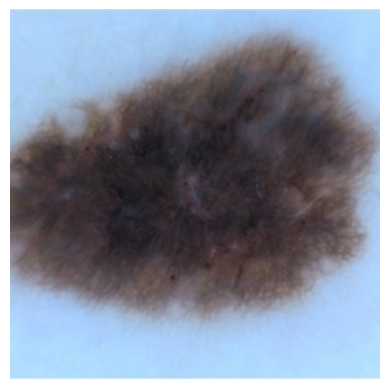

In [45]:
# To get the dataset it is required to create a Kaggle API token
import opendatasets as od
dataset_url = 'https://www.kaggle.com/datasets/nischaydnk/isic-2019-jpg-224x224-resized'
od.download(dataset_url)

df = pd.read_csv('isic-2019-jpg-224x224-resized/train-metadata.csv', index_col=0)

df.head() # dataset metadata

from PIL import Image
img = Image.open('isic-2019-jpg-224x224-resized/train-image/image/ISIC_0000000.jpg')
plt.imshow(img)
plt.axis('off')
plt.show()

# Step 3: Create Train and Test Folders

This step organizes the dataset by creating train and test directories and copying images into their respective folders based on their labels. This structure is necessary for using PyTorch's DataLoader to efficiently load and preprocess the data during training and evaluation

In [46]:
def create_train_test_folders(dataset_path, metadata_path, output_path):
    # Load metadata CSV
    df = pd.read_csv(metadata_path)

    # Split data into train and test
    train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['target'])

    # Create train and test directories
    train_dir = os.path.join(output_path, 'train')
    test_dir = os.path.join(output_path, 'test')
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # Copy images to train and test directories
    for index, row in train_df.iterrows():
        image_name = row['isic_id'] + '.jpg'
        image_path = os.path.join(dataset_path, image_name)
        target_folder = os.path.join(train_dir, str(row['target']))
        os.makedirs(target_folder, exist_ok=True)
        shutil.copy(image_path, target_folder)

    for index, row in test_df.iterrows():
        image_name = row['isic_id'] + '.jpg'
        image_path = os.path.join(dataset_path, image_name)
        target_folder = os.path.join(test_dir, str(row['target']))
        os.makedirs(target_folder, exist_ok=True)
        shutil.copy(image_path, target_folder)

dataset_path = 'isic-2019-jpg-224x224-resized/train-image/image'
metadata_path = 'isic-2019-jpg-224x224-resized/train-metadata.csv'
output_path = 'data'

create_train_test_folders(dataset_path, metadata_path, output_path)

train_dir = 'data/train'
test_dir = 'data/test'

# Step 4: Set Up Device

This step ensures that our code can run on either a GPU or CPU, depending on what is available. Try first with GPU because using a GPU can significantly speed up the training process for deep learning models

In [47]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' # setting up device agnostic code

In [48]:
# Step 4.5: Create DataLoaders and get class names

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=transform,
    batch_size=32
)

print(f"Classes: {class_names}")

Classes: ['0', '1']


# Step 5: Set Seed for Reproducibility

Setting a seed ensures reproducibility by fixing the random number generation. The create_writer function sets up TensorBoard logging, allowing us to visualize training metrics in real-time. This is useful for tracking the model's performance during training

In [49]:
def set_seed(seed:int=42):
    """Sets random seeds for torch operations.

    Args:
        seed (int, optional): The desired seed value. Defaults to 42.
    """
    torch.cuda.manual_seed(seed)
    torch.manual_seed(seed)

# Customizing the tensorboard logs
from datetime import datetime

def create_writer(experiment_name:str,
                  model_name:str,
                  extra:str=None):
    timestamp = datetime.now().strftime("%y-%m-%d")
    if extra:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)

    return SummaryWriter(log_dir=log_dir)

# Step 7: Define and Train the MLP Model


In [52]:
import torch
import torch.nn as nn
from modules.engine_binary import train

class CNN(nn.Module):
    def __init__(self, output_features):
        super(CNN, self).__init__()

        # Convolutional layers
        self.conv_stack = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Fully connected layers
        self.fc_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 256),  # Adjust the size based on the output of the conv layers
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_stack(x)
        x = self.fc_stack(x)
        #x = x.squeeze(dim=1)
        return x

# Initialize the CNN model
model_1 = CNN(output_features=1).to(device)  # Binary classification (output_features=1)

# Optimizer and scheduler
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

# Custom training loop
results_1 = {"train_loss": [], "train_acc": [], "train_recall": [], "test_loss": [], "test_acc": [], "test_recall": []}
results = train(
    model=model_1,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=50,
    device=device
)


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4089 | train_acc: 0.8315 | train_recall: 0.1726 | train_f1: 0.2386 | test_loss: 0.3808 | test_acc: 0.8391 | test_recall: 0.0266 | test_f1: 0.0435
Epoch: 2 | train_loss: 0.3855 | train_acc: 0.8406 | train_recall: 0.2107 | train_f1: 0.2926 | test_loss: 0.3817 | test_acc: 0.8376 | test_recall: 0.0435 | test_f1: 0.0672
Epoch: 3 | train_loss: 0.3729 | train_acc: 0.8459 | train_recall: 0.2496 | train_f1: 0.3369 | test_loss: 0.3576 | test_acc: 0.8513 | test_recall: 0.0453 | test_f1: 0.0673
Epoch: 4 | train_loss: 0.3574 | train_acc: 0.8508 | train_recall: 0.3070 | train_f1: 0.3916 | test_loss: 0.3293 | test_acc: 0.8621 | test_recall: 0.0604 | test_f1: 0.0867
Epoch: 5 | train_loss: 0.3484 | train_acc: 0.8536 | train_recall: 0.3199 | train_f1: 0.4080 | test_loss: 0.3370 | test_acc: 0.8568 | test_recall: 0.0619 | test_f1: 0.0858
Epoch: 6 | train_loss: 0.3319 | train_acc: 0.8600 | train_recall: 0.3700 | train_f1: 0.4540 | test_loss: 0.3147 | test_acc: 0.8688 | test_recall:

# Step 8: Save the Trained Models

After training both the Simple Perceptron and MLP models

In [55]:
import os

# Create a directory for saving models if it doesn't exist
os.makedirs("models", exist_ok=True)

# Save model
torch.save(model_1.state_dict(), "models/cnn_model.pth")
print("model saved.")

model saved.


# Step 9: Visualize and Compare Results

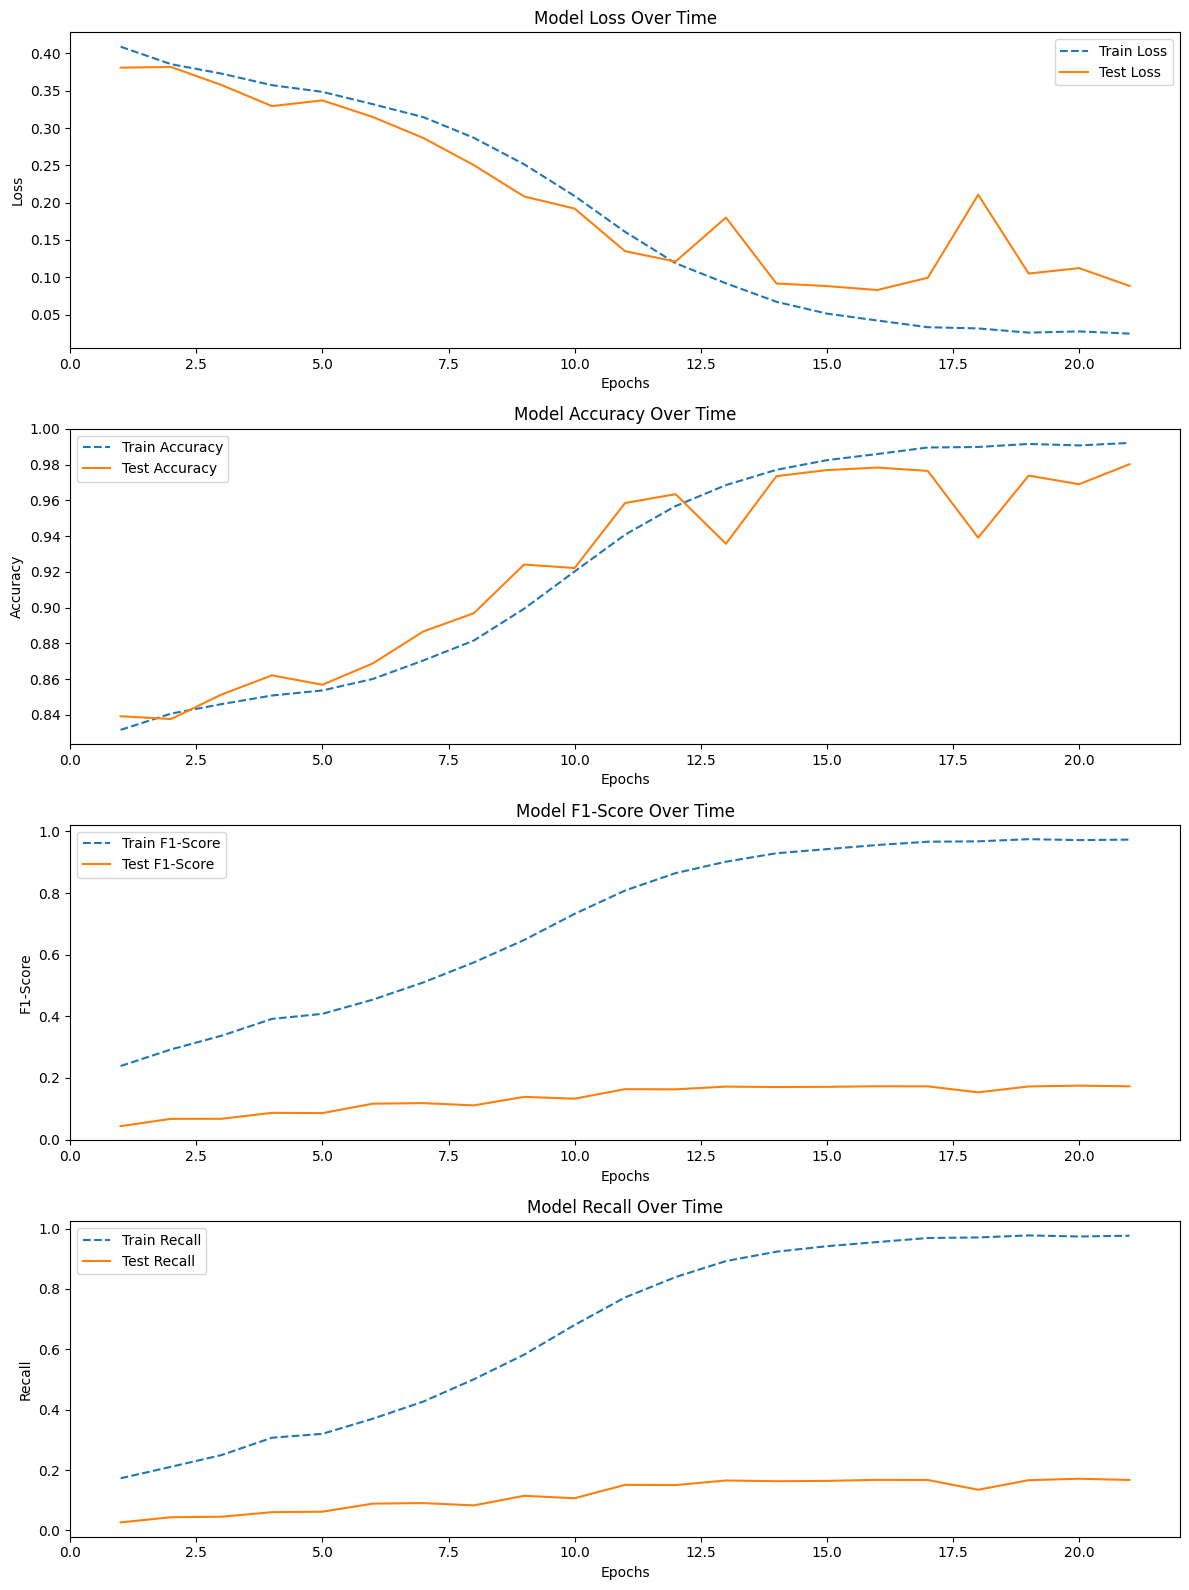

In [60]:
# Create a figure with 4 subplots, one for each metric

fig, axs = plt.subplots(4, 1, figsize=(12, 16))

# Plot training and testing loss
axs[0].plot(epochs, results['train_loss'], label='Train Loss', linestyle='--')
axs[0].plot(epochs, results['test_loss'], label='Test Loss', linestyle='-')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_title('Model Loss Over Time')
axs[0].legend()

# Plot training and testing accuracy
axs[1].plot(epochs, results['train_acc'], label='Train Accuracy', linestyle='--')
axs[1].plot(epochs, results['test_acc'], label='Test Accuracy', linestyle='-')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Model Accuracy Over Time')
axs[1].legend()

# Plot training and testing F1-Score
axs[2].plot(epochs, results['train_f1'], label='Train F1-Score', linestyle='--')
axs[2].plot(epochs, results['test_f1'], label='Test F1-Score', linestyle='-')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('F1-Score')
axs[2].set_title('Model F1-Score Over Time')
axs[2].legend()

# Plot training and testing Recall
axs[3].plot(epochs, results['train_recall'], label='Train Recall', linestyle='--')
axs[3].plot(epochs, results['test_recall'], label='Test Recall', linestyle='-')
axs[3].set_xlabel('Epochs')
axs[3].set_ylabel('Recall')
axs[3].set_title('Model Recall Over Time')
axs[3].legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


# Step 10: Load and Test Saved Models